In [1]:
import os
import sys
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

In [9]:
# ID    UTTERANCE    CORE RELATIONS
trainFile = pd.read_csv('dataset/hw1_train.csv')
# ID    UTTERANCE
testFile = pd.read_csv('dataset/hw1_test.csv')

In [10]:
# Data preparation

# input features
X = list(trainFile['UTTERANCE'])

unique_relations = []
for relation_str in trainFile['CORE RELATIONS']:
    relations = relation_str.split(' ')
    for relation in relations:
        if relation not in unique_relations:
            unique_relations.append(relation)

unique_nodes = []
for path in unique_relations:
    nodes = path.split('.')
    for node in nodes:
        if node not in unique_nodes:
            unique_nodes.append(node)

# add label columns to dataframe
for relation in unique_relations:
    trainFile[relation] = 0

# fill out label columns
for idx, relation_str in enumerate(trainFile['CORE RELATIONS']):
    relations = relation_str.split(' ')
    for relation in relations:
        trainFile.loc[idx,relation] = 1

#separate label columns
labels = trainFile[unique_relations]

# target values
y = labels.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 5000 words because the training set has almost 2500 unique words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [12]:
X_train.shape

(2670, 5000)

In [13]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
model = Sequential()
model.add(Dense(512, input_shape=(5000,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(46, activation='sigmoid'))
model.compile(loss='binary_crossentropy',              # categorical_crossentropy, binary_crossentropy f1_loss
              optimizer='adam',
              metrics=['accuracy', f1_score])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2560512   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                23598     
Total params: 2,846,766
Trainable params: 2,846,766
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)

Train on 2403 samples, validate on 267 samples
Epoch 1/100
2403/2403 [==============================] - 1s 597us/sample - loss: 0.1944 - accuracy: 0.9617 - f1_score: 0.0051 - val_loss: 0.0908 - val_accuracy: 0.9760 - val_f1_score: 0.0000e+00
Epoch 2/100
2403/2403 [==============================] - 0s 99us/sample - loss: 0.0785 - accuracy: 0.9768 - f1_score: 0.1112 - val_loss: 0.0606 - val_accuracy: 0.9814 - val_f1_score: 0.3605
Epoch 3/100
2403/2403 [==============================] - 0s 100us/sample - loss: 0.0487 - accuracy: 0.9848 - f1_score: 0.5636 - val_loss: 0.0413 - val_accuracy: 0.9886 - val_f1_score: 0.7082
Epoch 4/100
2403/2403 [==============================] - 0s 97us/sample - loss: 0.0319 - accuracy: 0.9902 - f1_score: 0.7596 - val_loss: 0.0361 - val_accuracy: 0.9902 - val_f1_score: 0.7673
Epoch 5/100
2403/2403 [==============================] - 0s 97us/sample - loss: 0.0220 - accuracy: 0.9932 - f1_score: 0.8491 - val_loss: 0.0312 - val_accuracy: 0.9910 - val_f1_score: 0.78

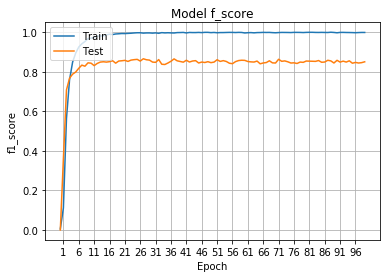

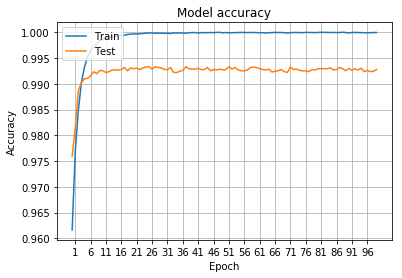

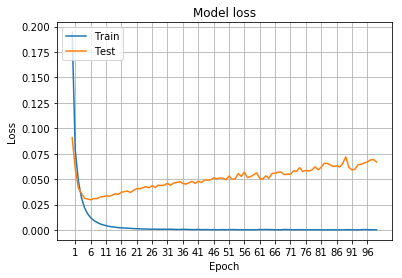

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation f_scores
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model f_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.xticks(np.arange(1, 100, 5))
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.xticks(np.arange(1, 100, 5))
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.xticks(np.arange(1, 100, 5))
plt.show()

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])
print("Test F1 score:", score[2])

668/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [23]:
# build final model
# 5000 words because the training set has almost 2500 unique words
tokenizer2 = Tokenizer(num_words=5000)
tokenizer2.fit_on_texts(X)
X_train = tokenizer2.texts_to_matrix(X)
y_train = y

model2 = Sequential()
model2.add(Dense(512, input_shape=(5000,), activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(46, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',              # categorical_crossentropy, binary_crossentropy f1_loss
              optimizer='adam',
              metrics=['accuracy', f1_score])

history2 = model2.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1)

Train on 3338 samples
Epoch 1/25
3338/3338 [==============================] - 1s 226us/sample - loss: 0.1617 - accuracy: 0.9674 - f1_score: 0.0041
Epoch 2/25
3338/3338 [==============================] - 0s 85us/sample - loss: 0.0619 - accuracy: 0.9809 - f1_score: 0.3644
Epoch 3/25
3338/3338 [==============================] - 0s 81us/sample - loss: 0.0354 - accuracy: 0.9891 - f1_score: 0.7328
Epoch 4/25
3338/3338 [==============================] - 0s 81us/sample - loss: 0.0232 - accuracy: 0.9929 - f1_score: 0.8392
Epoch 5/25
3338/3338 [==============================] - 0s 83us/sample - loss: 0.0162 - accuracy: 0.9950 - f1_score: 0.8909
Epoch 6/25
3338/3338 [==============================] - 0s 82us/sample - loss: 0.0118 - accuracy: 0.9963 - f1_score: 0.9210
Epoch 7/25
3338/3338 [==============================] - 0s 84us/sample - loss: 0.0087 - accuracy: 0.9972 - f1_score: 0.9402
Epoch 8/25
3338/3338 [==============================] - 0s 83us/sample - loss: 0.0067 - accuracy: 0.9980 - f1

In [24]:
X_t = list(testFile['UTTERANCE'])
X_pred = tokenizer2.texts_to_matrix(X_t)

In [25]:
y_pred = model2.predict(X_pred)

In [27]:
predictions = []
for y in y_pred:
    temp = ''
    for i,v in enumerate(y):
        if v > 0.5:
            temp += ' ' + unique_relations[i]
    if len(temp) < 1: temp = unique_relations[np.argmax(y)]
    # if len(temp)>= 2: print(temp)
    predictions.append(temp.strip())
# predictions

In [41]:
submissionFile = pd.DataFrame({
    'ID': [i for i in range(len(predictions))],
    'CORE RELATIONS': predictions})
path_to_save = os.path.abspath(os.getcwd()) + '/predictions/'
submissionFile.to_csv('predictions/prediction11.csv', index = None)
submissionFile.head()

,ID,CORE RELATIONS
0,0,movie.starring.actor
1,1,movie.starring.actor
2,2,movie.starring.actor
3,3,movie.starring.actor
4,4,movie.starring.actor
